In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
%load_ext autoreload
%autoreload 2


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-19 23:04:59 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [2]:
thetadata_start = '2021-01-01'

In [35]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 10
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# AMZN20220329LONG
# ttrades__ = ttrades__[ttrades__.index.isin([26,])]
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,105,504,551,103.049417,100.110001,-308.638768,-0.028524,2023-01-04,2023-03-14,69,SBUX
1,12,504,675,195.863123,213.759995,214.762462,0.091374,2023-01-04,2023-09-11,250,BA
2,894,514,752,17.095625,49.813000,29249.332740,1.913786,2023-01-19,2023-12-29,344,NVDA
3,14,517,687,358.781354,382.399994,330.660962,0.065830,2023-01-24,2023-09-27,246,NFLX
4,26,521,752,149.932939,358.989990,5435.483341,1.394337,2023-01-30,2023-12-29,333,META
5,139,524,683,84.585016,98.599998,1948.082575,0.165691,2023-02-02,2023-09-21,231,AMD
6,66,525,540,148.548104,147.710007,-55.314406,-0.005642,2023-02-03,2023-02-27,24,AAPL
7,63,545,708,154.328258,170.369995,1010.629422,0.103946,2023-03-06,2023-10-26,234,AAPL
8,96,575,587,109.251048,104.269997,-478.180907,-0.045593,2023-04-18,2023-05-04,16,SBUX
9,55,583,708,108.107058,120.629997,688.761639,0.115838,2023-04-28,2023-10-26,181,AMZN


In [4]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)


max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash
pd.Series(weights).sort_values(ascending=False), max_cash

(NVDA    0.183382
 AMD     0.141877
 SBUX    0.130273
 AAPL    0.118067
 TSLA    0.118042
 COST    0.095599
 AMZN    0.072041
 NFLX    0.064065
 META    0.047216
 BA      0.029439
 dtype: float64,
 {'NVDA': 2,
  'AMD': 2,
  'TSLA': 2,
  'AAPL': 2,
  'SBUX': 2,
  'NFLX': 2,
  'COST': 2,
  'AMZN': 2,
  'META': 2,
  'BA': 2})

In [5]:

# from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
# from pandas.tseries.offsets import BDay

# rm = RiskManager(None, None, 1000000)
# rm.OrderPicker.liquidity_threshold = 2
# rm.OrderPicker.lookback = 10
# rm.OrderPicker.data_availability_threshold = 0.15
# date, tick = '2023-07-05', 'AVGO'
# date, tick = '2024-08-13', 'TSM'
# start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
# right = 'C'
# order_settings = {'type': 'spread',
#  'specifics': [{'direction': 'long',
#    'rel_strike': .50,
#    'dte': 210,
#    'moneyness_width': 0.5},
#   #  {'direction': 'short',
#   # 'rel_strike': .60,
#   # 'dte': 270,
#   # 'moneyness_width': 0.35}
# ],
#  'name': 'vertical_spread'}



# order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
# order

In [36]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
evb_backtest.portfolio.initial_capital
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .85,
   'dte': 365,
   'moneyness_width': 0.10},
   {'direction': 'short',
  'rel_strike': .80,
  'dte': 365,
  'moneyness_width': 0.10}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.portfolio.min_moneyness_threshold = 5
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 30
evb_backtest.portfolio.moneyness_width_factor = .025
evb_backtest.portfolio.dte_reduction_factor = 30
evb_backtest.portfolio.min_acceptable_dte_threshold = 60
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])



signals = evb_backtest.bars.signal_df
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

19.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [37]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['SBUX20240119C115'], 'short': ['SBUX20240119C120'], 'trade_id': '&L:SBUX20240119C115&S:SBUX20240119C120', 'close': 1.8000000000000007}, Date: 2023-01-04, Signal: SignalEvent type:LONG, symbol=SBUX, date:2023-01-04 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:SBUX20230104LONG
Max Contract Price: 2, Cash at Hand: 19.93171833411369
Cash at Hand 19.93171833411369 Close 1.8000000000000007
Processing event: SIGNAL
Buy Details
Position: {'long': ['BA20240119C225'], 'short': ['BA20240119C230'], 'trade_id': '&L:BA20240119C225&S:BA20240119C230', 'close': 1.9250000000000043}, Date: 2023-01-04, Signal: SignalEvent type:LONG, symbol=BA, date:2023-01-04 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:BA20230104LONG
Max Contract Price: 2, Cash at Hand: 4.504113905635004
Cash at Hand 4.504113905635004 Close 1.9250000000000043
Processing event: ORDER
Buy Order Position: {'long': ['SB

In [29]:
pd.set_option('display.max_rows', 100)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol=='SBUX']

,signal_id,datetime,symbol,direction,cash_before,cash_after
0,SBUX20230104LONG,2023-01-04,SBUX,BUY,2214.635370,270.169885
9,SBUX20230104LONG,2023-03-14,SBUX,SELL,270.169885,1370.291376
10,SBUX20230418LONG,2023-04-19,SBUX,BUY,1370.291376,191.838489
12,SBUX20230418LONG,2023-05-04,SBUX,SELL,191.838489,1021.498344
23,SBUX20231108LONG,2023-11-08,SBUX,BUY,1021.498344,133.896191
28,SBUX20231108LONG,2023-12-05,SBUX,SELL,133.896191,544.446739


In [30]:

trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades[['Positions','EntryTime', 'ExitTime','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue',  'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]
# trades#[['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue']]

,Positions,EntryTime,ExitTime,Ticker,PnL,ReturnPct,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,EntryPrice,ExitPrice,Quantity,SignalID,Duration
0,&L:SBUX20240119C120&S:SBUX20240119C125,2023-01-04,2023-03-14,SBUX,-844.343994,-0.434229,162.038790,91.676791,1928.865486,1115.721492,162.038790,91.676791,12,SBUX20230104LONG,69
1,&L:BA20240119C235&S:BA20240119C240,2023-01-04,2023-09-11,BA,-144.223146,-0.373446,193.097576,120.986003,383.595152,244.572006,193.097576,120.986003,2,BA20230104LONG,250
2,&L:NVDA20240119C205&S:NVDA20240119C210,2023-01-19,2023-12-20,NVDA,3601.605926,1.321927,194.608030,451.865596,2706.312419,6344.318345,194.608030,451.865596,14,NVDA20230119LONG,335
3,&L:NFLX20240119C455&S:NFLX20240119C460,2023-01-24,2023-09-27,NFLX,-589.600715,-0.607037,161.879327,63.612541,963.475961,389.475246,161.879327,63.612541,6,NFLX20230124LONG,246
4,&L:META20240119C170&S:META20240119C175,2023-01-30,2023-12-21,META,1026.072766,1.437335,178.467888,434.986079,708.671551,1745.144318,178.467888,434.986079,4,META20230130LONG,325
5,&L:AMD20240119C100&S:AMD20240119C105,2023-02-02,2023-09-21,AMD,51.407424,0.024357,175.882470,180.166422,2094.989635,2177.597058,175.882470,180.166422,12,AMD20230202LONG,231
6,&L:AAPL20240119C190&S:AAPL20240119C200,2023-02-03,2023-02-27,AAPL,-498.721198,-0.285456,194.122539,138.709073,1735.402854,1260.081657,194.122539,138.709073,9,AAPL20230203LONG,24
7,&L:AAPL20240315C195&S:AAPL20240315C205,2023-03-06,2023-10-26,AAPL,-452.531076,-0.372962,202.224018,126.802173,1205.544111,768.613035,202.224018,126.802173,6,AAPL20230306LONG,234
8,&L:SBUX20240119C125&S:SBUX20240119C130,2023-04-19,2023-05-04,SBUX,-348.793032,-0.295975,117.845289,82.965986,1165.452887,842.659855,117.845289,82.965986,10,SBUX20230418LONG,15
9,&L:AMZN20240315C135&S:AMZN20240315C145,2023-04-28,2023-10-26,AMZN,448.023010,0.476852,187.908651,277.513253,933.043253,1394.066263,187.908651,277.513253,5,AMZN20230428LONG,181


In [31]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{}

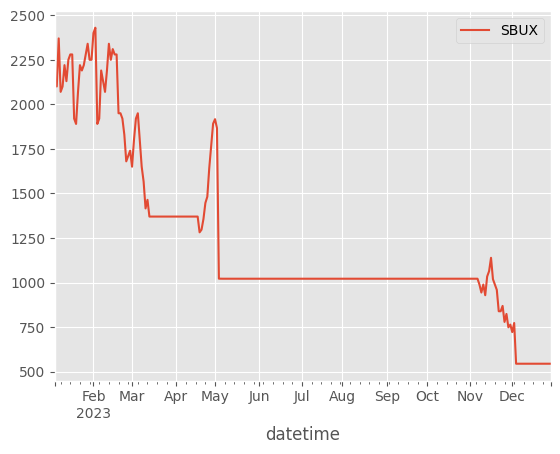

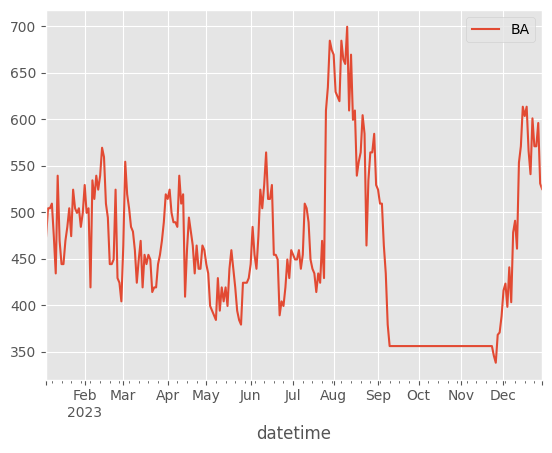

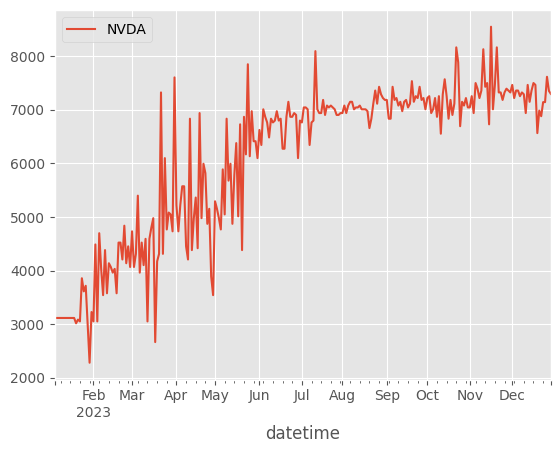

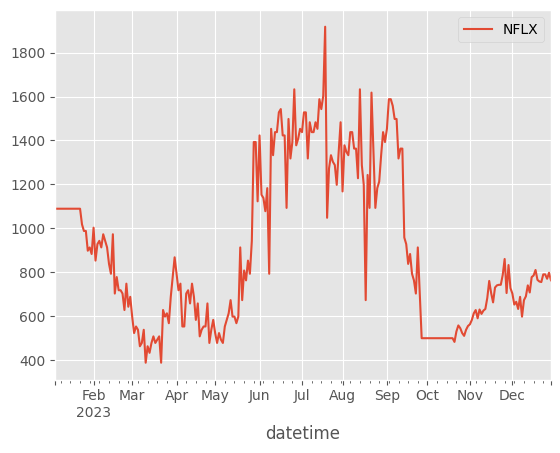

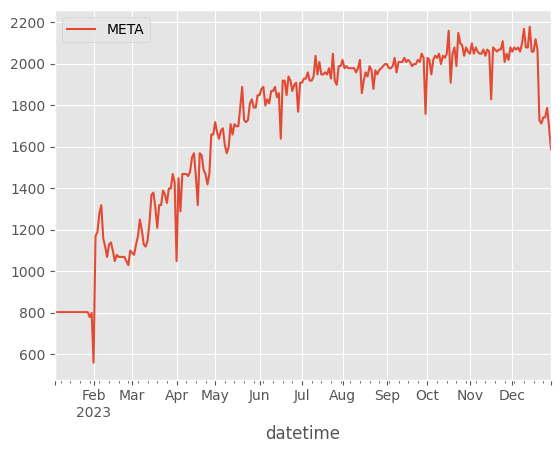

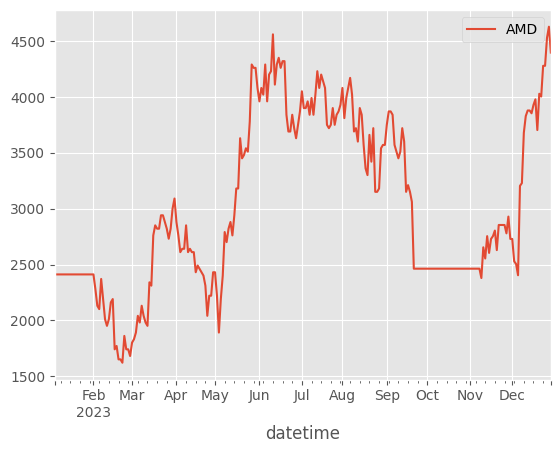

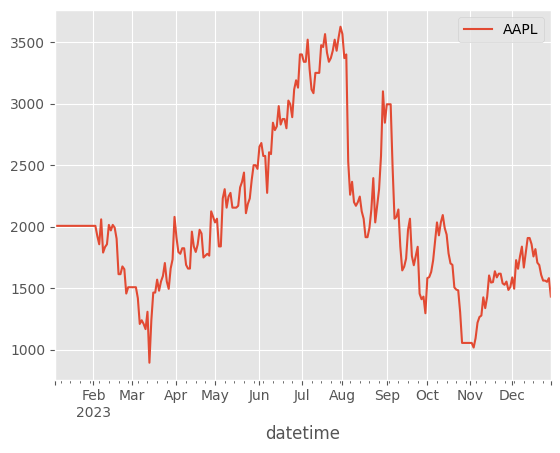

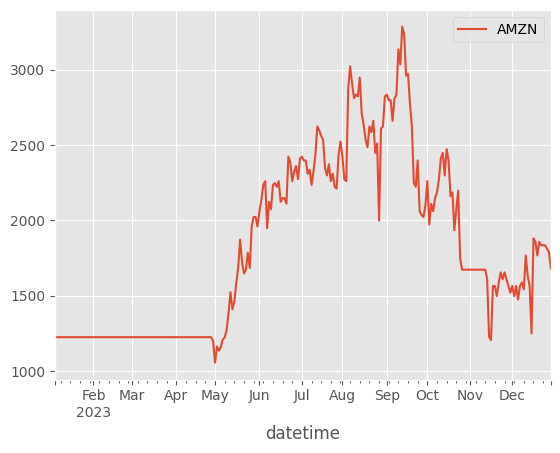

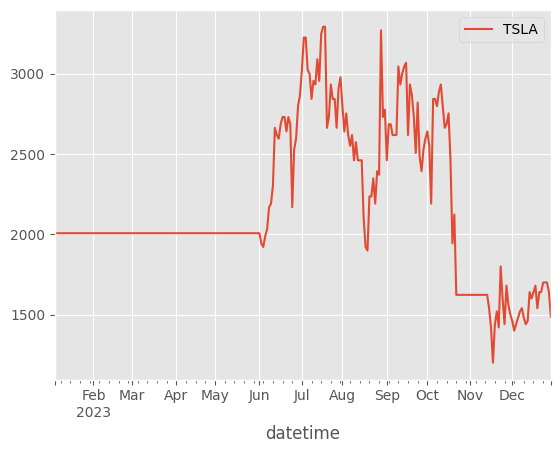

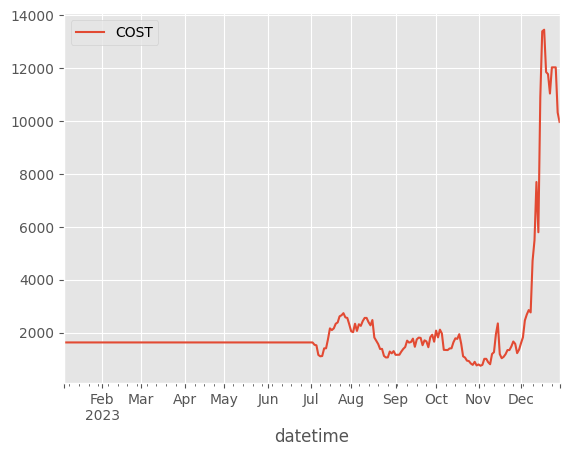

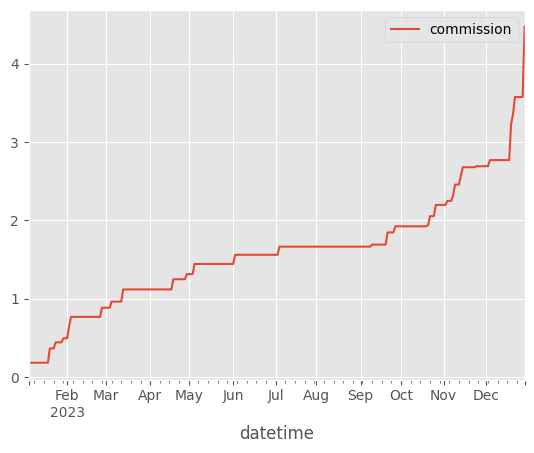

In [32]:
# evb_backtest.portfolio._equity.plot(y = 'COST'), evb_backtest.portfolio._equity.plot(y = 'AAPL'), evb_backtest.portfolio._equity.plot(y = 'NVDA')
for col in evb_backtest.portfolio._equity.columns:
    if col not in ['cash', 'Total']:
        evb_backtest.portfolio._equity.plot(y = col)
        plt.show()

In [33]:
evb_backtest.portfolio.plot_portfolio()

In [13]:
evb_backtest.portfolio.aggregate()

Start                                                    2023-01-04 00:00:00
End                                                      2023-12-29 00:00:00
Duration                                                   359 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    27439.57
Equity Peak [$]                                                 29963.625326
Return [%]                                                         37.745672
Buy & Hold Return [%]                                              65.539444
CAGR [%]                                                           38.484888
Volatility Ann. [%]                                                68.751124
Sharpe Ratio                                                        0.813238
Sortino Ratio                                                       1.213916
Skew                                                                0.377562

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-07-03,4.90,4.90,4.90,4.90,0.0,-35.0,5.30,12.0,5.75,5.525,6.974138
2023-07-05,4.73,5.33,4.73,5.33,0.0,2.0,5.60,0.0,5.60,5.600,5.561538
2023-07-06,6.75,4.85,6.75,4.85,-3.0,0.0,5.20,0.0,5.15,5.175,5.175000
2023-07-07,4.70,4.70,3.45,3.45,2.0,6.0,4.10,-17.0,4.35,4.225,3.650236
2023-07-10,5.19,5.25,5.19,5.25,5.0,-2.0,5.35,12.0,5.85,5.600,5.901206
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,138.00,138.00,133.53,133.53,2.0,0.0,8.05,0.0,8.90,8.475,8.730000
2023-12-21,134.20,134.20,129.92,133.40,5.0,19.0,8.45,-4.0,9.05,8.750,7.216667
2023-12-22,9.11,10.59,9.11,10.55,-3.0,1.0,7.20,-25.0,9.65,8.425,6.727778


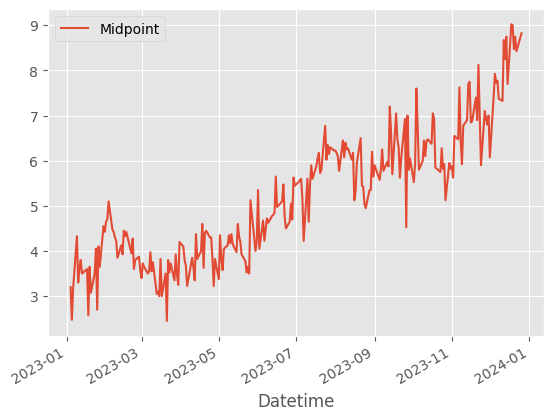

In [14]:
# &L:COST20240621C550&S:COST20240621C560	2023-07-03	2023-12-29
price_data = evb_backtest.portfolio.options_data['COST20240621C550'] - evb_backtest.portfolio.options_data['COST20240621C560']
# price_data = evb_backtest.portfolio.options_data['COST20240621C560']
price_data.plot(y = 'Midpoint')
price_data[(price_data.index >= '2023-07-03') & (price_data.index <= '2023-12-29')]
# price_data#[price_data.index.isin(['2022-01-04', '2022-01-21'])]

In [15]:
# COST20240621C550
retrieve_eod_ohlc('COST',
                  '2024-01-15',
                  '2024-06-21',
                  'C',
                  '2023-07-03',
                  560.0,
                  print_url=True)

http://127.0.0.1:25510/v2/hist/option/eod?end_date=20240115&root=COST&use_csv=true&exp=20240621&right=C&start_date=20230703&strike=560000


,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-07-03,43.23,43.23,43.23,43.23,1,48,42.10,10,45.15,43.625,42.625862
2023-07-03,43.23,43.23,43.23,43.23,1,48,42.10,10,45.15,43.625,42.625862
2023-07-05,43.25,43.32,43.25,43.32,2,16,43.55,10,44.95,44.250,44.088462
2023-07-05,43.25,43.32,43.25,43.32,2,16,43.55,10,44.95,44.250,44.088462
2023-07-06,42.00,43.90,42.00,43.90,4,15,42.30,15,44.40,43.350,43.350000
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,0.00,0.00,0.00,0.00,0,16,118.25,7,120.70,119.475,118.995652
2024-01-09,0.00,0.00,0.00,0.00,0,21,121.75,31,124.90,123.325,123.627885
2024-01-10,0.00,0.00,0.00,0.00,0,6,125.20,7,132.05,128.625,128.888462


In [16]:
(1.235/1.950)-1

-0.3666666666666666

In [17]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                  short  \
datetime   symbol                                                 
2023-01-04 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-05 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-06 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-09 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-10 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-11 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-12 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-13 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-16 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-17 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-18 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
2023-01-19 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
2023-01-20 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
2023-01-23 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
2023-01-24 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
           NFLX       [NFLX20240119C455]     [NFLX20240119C460]   
2023-01-25 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
           NFLX       [NFLX20240119C455]     [NFLX20240119C460]   
2023-01-26 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
           NFLX       [NFLX20240119C455]     [NFLX20240119C460]   
2023-01-27 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
           NFLX       [NFLX20240119C455]     [NFLX20240119C460]   
2023-01-30 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
           NFLX       [NFLX20240119C455]     [NFLX20240119C460]   
           META       [META20240119C165]     [META20240119C170]   
2023-01-31 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA           [BA20240119C220]       [BA20240119C225]   
           NVDA       [NVDA20240119C205]     [NVDA20240119C210]   
           NFLX       [NFLX20240119C455]     [NFLX20240119C460]   
           META       [META20240119C165]     [META20240119C170]   
2023-02-01 SBUX       [SBUX20240119C115]     [SBUX20240119C120]   
           BA   

In [18]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [19]:
evb_backtest.portfolio.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')